In [4]:
%matplotlib inline

import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression

In [5]:
from utils.preprocess_data import preprocessing, get_nb_msg, treat_msg_season
from utils.evaluation_utils import confidence_interval, evaluate_model
from utils.models import get_class_weights

# Getting the dataset

We will use here the dataset provided by the authors we will create a helper function to extract the features that we want.

In [6]:
data = pd.read_json("diplomacy_data/diplomacy_data.json")
df = preprocessing(data)
df.head()

sentiment_positive  sentiment_neutral  sentiment_negative  \
idx season                                                              
0   1906.5                   0                  0                   2   
    1906.5                   1                  1                   4   
    1906.5                   1                  2                   1   
    1906.5                   4                  2                  13   
    1906.5                   1                  3                   5   

            n_requests                                     frequent_words  \
idx season                                                                  
0   1906.5           1  [just, bot, ,, ., take, unit, war, retreat, di...   
    1906.5           2  [armies, north, the, armies, on, ., your, with...   
    1906.5           2  [?, going, for, ser, balance, a, to, of, give,...   
    1906.5           8  [only, he, alb, ., forced, italy's, is, be, .,...   
    1906.5           7  [more, let, keep, we, side, we, don't, to, ., ...   

            n_words  politeness  n_sentences  n_disc_words  \
idx season                                                   
0   1906.5       35    0.367200            2             7   
    1906.5       77    0.932326            6            16   
    1906.5       55    0.983373            4            14   
    1906.5      313    0.957072           19            71   
    1906.5      146    0.832023            9            38   

                                                   disc_words  \
idx season                                                      
0   1906.5  [just, war, prefer, really, light, retreat, in...   
    1906.5  [against, lose, even, loss, support, attack, g...   
    1906.5  [rather, light, would, lose, retreat, could, p...   
    1906.5  [so, so, before, while, before, still, as long...   
    1906.5  [before, still, move, ally, will, want, will, ...   

                                                    all_words      role  \
idx season                                                                
0   1906.5  [that, prefer, from, mos, can, really, ., i'd,...    victim   
    1906.5  [we, after, an, can, mos, lose, won't, france,...    victim   
    1906.5  [after, ?, mos, lose, a, thanks, ., i'd, it, p...    victim   
    1906.5  [a, stuck, while, lack, build, like, with, all...    victim   
    1906.5  [prevent, a, with, our, be, retreat, didn't, ,...  betrayer   

            betrayal  season_betrayal  season_before_betrayal  \
idx season                                                      
0   1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   

            friendship_length  
idx season                     
0   1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0

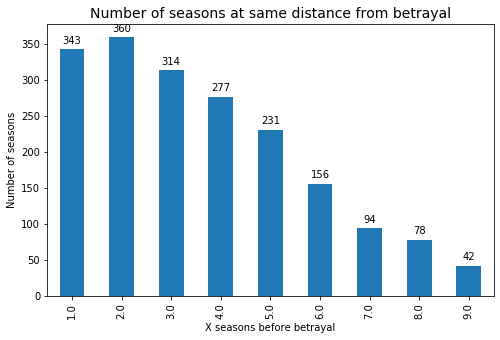

In [35]:
number_seasons_before_betrayal = df[(df["betrayal"]==True) & (df["role"] == "betrayer")].reset_index().groupby('season_before_betrayal').count()['idx']

plt.figure(figsize=(8, 5))
ax = number_seasons_before_betrayal.plot(kind='bar')
ax.set_xlabel("X seasons before betrayal")
ax.set_ylabel('Number of seasons')
ax.set_title('Number of seasons at same distance from betrayal', fontsize=14)
# ax.set_xticklabels(list(number_seasons_before_betrayal))

for rect, label in zip(ax.patches, list(number_seasons_before_betrayal)):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

There are 367 instances of 1 season before betrayal, 379 instances of 2 seasons before betrayal etc.

# Predict Imminent Betrayal

Done similar to the authors in Section 5 to see if we can improve results. 

## Models

### Prepare input data

In [8]:
features_data = df.copy()

# Consider only the betrayals relationships
features_data = features_data[features_data['betrayal'] == True]

# Drop words as we cannot consider as features here and betrayal infos
features_data = features_data.drop(columns=['frequent_words', 'all_words', 'season_betrayal', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season', 'role'], as_index=True).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'n_disc_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'friendship_length': 'min', # Same
    'season_before_betrayal': 'min' # Same
})

aggreagted_features_per_season.head()

sentiment_positive  sentiment_neutral  \
idx season role                                              
0   1906.5 betrayer            1.333333           1.333333   
           victim              1.500000           1.250000   
    1907.0 betrayer            0.142857           0.857143   
           victim              1.333333           0.666667   
    1907.5 betrayer            2.000000           2.500000   

                     sentiment_negative  n_requests  n_words  n_disc_words  \
idx season role                                                              
0   1906.5 betrayer            1.500000    3.666667      489           120   
           victim              5.000000    3.250000      480           108   
    1907.0 betrayer            1.285714    1.285714      280            46   
           victim              1.000000    0.666667       93            15   
    1907.5 betrayer            2.000000    5.500000      333            87   

                     politeness  n_sentences  friendship_length  \
idx season role                                                   
0   1906.5 betrayer    0.803328           25                3.0   
           victim      0.809993           31                3.0   
    1907.0 betrayer    0.560083           16                3.0   
           victim      0.785508            9                3.0   
    1907.5 betrayer    0.982703           13                3.0   

                     season_before_betrayal  
idx season role                              
0   1906.5 betrayer                     6.0  
           victim                       6.0  
    1907.0 betrayer                     5.0  
           victim                       5.0  
    1907.5 betrayer                     4.0

In [9]:
features_per_season = aggreagted_features_per_season.reset_index()

# Add difference between politeness score in victim and betrayer
def delta_politeness(x):
    return {'delta_role_politeness': (x[x['role'] == 'betrayer']['politeness'].values - x[x['role'] == 'victim']['politeness'].values).item()}
delta_politeness_role = features_per_season.groupby(by=['idx', 'season']).apply(lambda x: pd.Series(delta_politeness(x))).reset_index()


def get_politeness_season(features_per_season):
    data_time = features_per_season.groupby(['idx']).apply(lambda x: pd.Series({
        'delta_time': x['politeness'].values - np.append(x['politeness'].values[0], x['politeness'].values[:-1])
}))
    delta_time_list = list()
    for dt in data_time['delta_time']:
        delta_time_list = np.append(delta_time_list, dt)
    return delta_time_list
features_per_season['delta_time_politeness'] = get_politeness_season(features_per_season)

# Consider just betrayer data
input_features = features_per_season[features_per_season['role'] == 'betrayer'].set_index(['idx', 'season']).join(delta_politeness_role.set_index(['idx', 'season'])).reset_index()

X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_requests', 'n_words', 'politeness', 'n_sentences', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype('float32')
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,politeness,n_sentences,delta_role_politeness,delta_time_politeness,friendship_length
0,1.333333,1.333333,1.500000,3.666667,489,0.803328,25,-0.006665,0.000000,3.0
1,0.142857,0.857143,1.285714,1.285714,280,0.560083,16,-0.225425,-0.249910,3.0
2,2.000000,2.500000,2.000000,5.500000,333,0.982703,13,0.375372,0.197195,3.0
3,1.800000,0.800000,2.200000,3.200000,449,0.748802,24,0.177667,0.141471,3.0
4,1.000000,1.000000,1.000000,2.000000,78,0.899161,6,0.335738,0.328027,3.0


### How we bootstrap model predictions

In [10]:
from scipy.stats import sem

def bootstrap_model_prediction(train_and_predict_fn, n_iterations, stratify, model_name):
    """Use to run the model for a number of iterations and get bootstrapped results."""

    print('Training model {}..'.format(model_name))

    f1_scores = []
    mmc_scores = []
    for i in range(n_iterations):

        # Split data before resampling
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

        # Resample train and test data, stratifying on y (resulting in equal number of 0 and 1 labels)
        if stratify:
            x_train, y_train = resample(x_train, y_train, replace=True, stratify=y_train)
        else:
            x_train, y_train = resample(x_train, y_train, replace=True)

        x_test, y_test = resample(x_test, y_test, replace=True)

        scores = train_and_predict_fn(x_train, x_test, y_train, y_test)

        # We store the f1 and mmc scores only to compare to authors' baseline
        f1_scores.append(scores['f1'])
        mmc_scores.append(scores['mmc'])
    f1_score_low, f1_score_upper = confidence_interval(0.95, f1_scores)
    mmc_score_low, mmc_score_upper = confidence_interval(0.95, np.nan_to_num(mmc_scores))

    f1_avg_score, f1_avg_score_err = np.mean(f1_scores), sem(f1_scores)
    mmc_avg_score, mmc_avg_score_err = np.mean(mmc_scores), sem(mmc_scores)

    print('Average F1-Score: %.3f' % f1_avg_score)
    print('Average MMC-Score: %.3f' % mmc_avg_score)
    print('F1-Score: 95%% confidence interval %.3f and %.3f' % (f1_score_low, f1_score_upper))
    print('Matthews Corr Coef: 95%% confidence interval %.3f and %.3f' % (mmc_score_low, mmc_score_upper))

    return [f1_avg_score, f1_avg_score_err], [mmc_avg_score, mmc_avg_score_err]

### Logistic Regression

In [41]:
all_models_f1_scores = []
all_models_mmc_scores = []
all_models_names = []

def add_results(f1_out, mmc_out, name):
    all_models_f1_scores.append(f1_out)
    all_models_mmc_scores.append(mmc_out)
    all_models_names.append(name)

In [48]:
def train_and_predict_logistic_regressionl_normalized(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    clf = LogisticRegression(random_state=0, class_weight=get_class_weights(Y)).fit(x_train, y_train)                                       
    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=False, model_name="Logistic Regression (Nor)")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regression (Nor)")
add_results(f1_output, mmc_output, "Logistic Regression")

Training model Logistic Regression (Nor)..
Average F1-Score: 0.492
Average MMC-Score: 0.333
F1-Score: 95% confidence interval 0.177 and 0.675
Matthews Corr Coef: 95% confidence interval -0.071 and 0.566

Training model Logistic Regression (Nor)..
Average F1-Score: 0.500
Average MMC-Score: 0.344
F1-Score: 95% confidence interval 0.326 and 0.658
Matthews Corr Coef: 95% confidence interval 0.061 and 0.555


### How we discovered the length of friendship matters

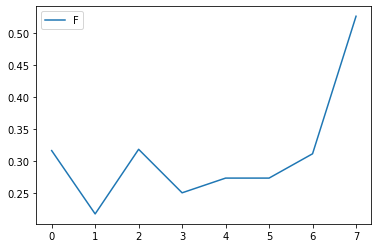

In [49]:
def log_reg_pipeline(features, print_=True):
    x_features = X[features].values
    x_train, x_test, y_train, y_test = train_test_split(x_features, Y, test_size=0.10, random_state=42)
    result = train_and_predict_logistic_regressionl_normalized( x_train, x_test, y_train, y_test)
    if print_:
        print("score on the test set : {}".format(result['f1']))
    return result['f1']

features_test = [
            ['politeness'],
            ['n_words', 'politeness', 'delta_role_politeness', 'delta_time_politeness'],
            ['n_words', 'politeness'],
            ['n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness', 'friendship_length'],
]

scores = []

for feature in features_test:
    score_nor = log_reg_pipeline(feature, False)
    scores.append(score_nor)
    
_ = plt.plot(np.arange(len(scores)), scores)
_ = plt.legend('F1 Score')

There is an evidence that including the friendship length can help for making the right decision ! Let's do a greedy search to cover as much possibilities as we can.

In [2]:
features_all = ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness', 'friendship_length', 'delta_time_politeness', 'delta_role_politeness']

In [12]:
from itertools import combinations

def greedy_search(X, features_all):
    list_features = []
    for i in range(len(features_all)):
        list_features += list(combinations(features_all, i+1))
    max_f1 = 0
    best_comb = ""
    for feat in list_features:
        features = [t for t in feat]
        x_features = X[features].values
        x_train, x_test, y_train, y_test = train_test_split(x_features, Y, test_size=0.10, random_state=42)
        result = train_and_predict_logistic_regressionl_normalized( x_train, x_test, y_train, y_test)
        if result["f1"] > max_f1:
            max_f1 = result["f1"]
            best_comb = features
    return max_f1, best_comb

In [13]:
max_f1, best_comb = greedy_search(X, features_all)
print("Best score : {} achieved with : {}".format(max_f1, best_comb))

/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))


Best score : 0.595 achieved with : ['sentiment_positive', 'sentiment_neutral', 'n_requests', 'politeness', 'friendship_length']


### Decision Trees

#### Random Forest

In [146]:
from sklearn.ensemble import RandomForestClassifier

features = ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_requests', 'n_words', 'politeness', 'n_sentences', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']
X = input_features[features]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype(np.int)

def train_and_predict_random_forest(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    clf = RandomForestClassifier(
        n_estimators=300, 
        max_depth=15, 
        class_weight='balanced_subsample')
        
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=False, model_name="Random Forest")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=True, model_name="Random Forest")
add_results(f1_output, mmc_output, "Random Forest")

Training model Random Forest..


/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))


Average F1-Score: 0.116
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.295
Matthews Corr Coef: 95% confidence interval -0.076 and 0.334

Training model Random Forest..


/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))


Average F1-Score: 0.052
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.235
Matthews Corr Coef: 95% confidence interval -0.067 and 0.299


{'acc': 0.776,
 'f1': 0.118,
 'fn': 14,
 'fp': 1,
 'mmc': 0.116194,
 'precision': 0.5,
 'recall': 0.067,
 'tn': 51,
 'tp': 1}

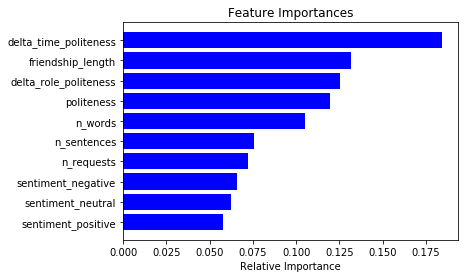

In [475]:
def train_rf_and_plot_importance(x_train, x_test, y_train, y_test ):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(x_train, y_train)

    importances = np.array(clf.feature_importances_)
    indices = np.argsort(importances)

    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), np.array(features)[indices])
    plt.xlabel('Relative Importance')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
train_rf_and_plot_importance(x_train, x_test, y_train, y_test)
train_and_predict_random_forest(x_train, x_test, y_train, y_test)

#### XGBoost

In [109]:
import xgboost

def train_and_predict_random_forest(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    ratio = float(np.sum(Y == 0)) / np.sum(Y == 1)
    
    clf = xgboost.XGBClassifier(n_jobs=-1, scale_pos_weight=ratio, n_estimators=300, max_depth=20)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=False, model_name="XGBoost")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=True, model_name="XGBoost")
add_results(f1_output, mmc_output, "XGBoost")

Training model XGBoost..
Average F1-Score: 0.479
Average MMC-Score: 0.440
F1-Score: 95% confidence interval 0.335 and 0.667
Matthews Corr Coef: 95% confidence interval 0.278 and 0.635

Training model XGBoost..
Average F1-Score: 0.654
Average MMC-Score: 0.632
F1-Score: 95% confidence interval 0.422 and 0.897
Matthews Corr Coef: 95% confidence interval 0.423 and 0.870


### Feed Forward Neural Network

In [19]:
from utils.models import get_feed_forward_model, local_seed

BATCH_SIZE = 64
EPOCHS = 10
FEATURES_NUM = X.shape[-1]

model = get_feed_forward_model(FEATURES_NUM)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________


In [490]:
def train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

    class_weights = get_class_weights(Y)
    with local_seed(10):
        model = get_feed_forward_model()
        result = model.fit(
            x_train, 
            y_train, 
            batch_size = BATCH_SIZE, 
            epochs=10,
            callbacks=[es],
            validation_data=(x_test, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step(x_test).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2)
print(train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test))

f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_feed_forward_model, 20, stratify=True, model_name="Feedforward")
add_results(f1_output, mmc_output, "Feed Forward NN")

{'f1': 0.362, 'mmc': 0.08248, 'acc': 68.368, 'precision': 0.233, 'recall': 0.474, 'tp': 1953, 'fp': 6426, 'tn': 7140, 'fn': 2170}
Training model Feedforward..
Average F1-Score: 0.454
Average MMC-Score: 0.287
F1-Score: 95% confidence interval 0.352 and 0.631
Matthews Corr Coef: 95% confidence interval 0.145 and 0.550


# Plot model results

In [517]:
# Ading authors baseline

all_models_f1_scores.append([0.31, 0])
all_models_mmc_scores.append([0.15, 0])
all_models_names.append('Authors baseline')

f1_scores  = np.array(all_models_f1_scores)
mmc_scores = np.array(all_models_mmc_scores)

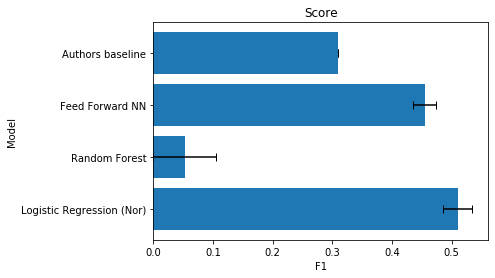

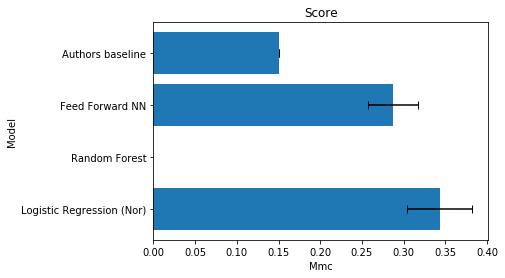

In [518]:
plt.barh(all_models_names, f1_scores[:, 0], xerr=f1_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("f1".capitalize())
plt.ylabel("Model")
plt.show()

plt.barh(all_models_names, mmc_scores[:, 0], xerr=mmc_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("mmc".capitalize())
plt.ylabel("Model")
plt.show()

# Explore more models using word embeddings

In [8]:
%%capture
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

### Get the new inputs: words embeddings

In [9]:
features_data = df.copy()
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfkAAAEWCAYAAABlpO6zAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAfXUlEQVR4nO3deZRcZZ3/8ffHBNkFVNDI1gi4ARJJYMQFYVBQEXRGHEVREI+OyLiMy8gcHAmjKCrjIC6DuIGCEvE3OoiI4MguMCYsCYioLIq4IZtsIobv74+60aLtdFfSVV2dm/frnDp973Of+9xv3aTzqbukbqoKSZLUPg8bdgGSJGkwDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJK70kz0ry/SR3JrktyUVJdhx2XdKwzRx2AZI0GUkeAZwOHAx8FXg48Gzg/j5uY0ZVLenXeNJU8Uhe0sruCQBV9ZWqWlJV91XVWVW1CCDJ65Nck+SuJD9MskPT/uQk5ya5I8nVSfZZOmCSE5L8V5IzktwD7JZk9SRHJ/l5kt8kOS7JmkN5x1KPDHlJK7sfA0uSnJjkBUk2WLogycuAecBrgEcA+wC3JlkN+CZwFrAR8Gbg5CRP7Br3lcCRwLrAhcBRdD5QzAa2AjYG3jvYtyZNTvzuekkruyRPBt4NPBd4LHAG8Hrgi8AZVfWxUf2fDZwKPK6qHmzavgJcW1XzkpwAPKyqXtMsC3A38NSquq5p2xn4clVtMQVvUVohXpOXtNKrqmuAAwGSPAk4CTgG2BS4boxVHgfctDTgGz+jc3S+1E1d0xsCawELO3kPQIAZfShfGhhP10tqlar6EXACsC2doN5yjG6/BDZN0v1v4GbAzd1DdU3/DrgP2Kaq1m9e61XVOn0tXuozQ17SSi3Jk5K8I8kmzfymwH7AJcBngXcmmZOOrZJsDlwK3Av8S5LVkuwK7A2cMtY2miP+zwD/mWSjZjsbJ9lz0O9PmgxDXtLK7i7gb4BLmzvhLwGuAt5RVafSuXnuy02/bwCPrKo/0gn1F9A5Sv8U8JrmLMCyvBv4KXBJkt8D3wWeOE5/aei88U6SpJbySF6SpJYy5CVJailDXpKkljLkJUlqKb8MRwP36Ec/ukZGRoZdhiStVBYuXPi7qtpwMmMY8hq4kZERFixYMOwyJGmlkuRnkx3D0/WSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWUIS9JUkv5ZTgauMU338nIod8adhmaYjcetdewS5BWeR7JS5LUUoa8JEktZchLktRShrwkSS1lyEuS1FKGvCRJLWXIS5LUUoa8JEktZchLktRShrwkSS1lyEuS1FKGvCRJLWXIS5LUUoa8JEktZchLktRShrwkSS1lyEsaiF133XXYJUirvFU+5JO8JEkleVKP/d+WZK2u+bsHVx0kGUly1QDH3zXJ6c30PkkOHdS2tGo577zzhl2CtMpb5UMe2A+4sPnZi7cBa03YqwdJZvZjnH6pqtOq6qhh1yFJ6o9VOuSTrAM8C3gd8Iqu9j8f3Tbzn0hyYJK3AI8DzklyTtfyI5NcmeSSJI9p2kaSfC/JoiT/m2Szpv2EJMcluRT4cJLnJLmieV2eZN0xSp2Z5OQk1yT52tIzCUnem+QHSa5KcnySNO1vSfLDZtunNG1rJ/l8kv9rtvPiMfbHgUk+0VXnsUm+n+T6JPt29XtXs91FSY5Y4T8ASdJArdIhD7wYOLOqfgzcmmTOeJ2r6ljgl8BuVbVb07w2cElVbQ+cD7y+af84cGJVPRU4GTi2a6hNgGdU1duBdwKHVNVs4NnAfWNs+onAp6rqycDvgTc17Z+oqh2raltgTeBFTfuhwNOabb+xaTsM+F5V7QTsBnwkydrjvV9gFp0PQS8CjgJIsgewNbATMBuYk2SX0SsmeUOSBUkWLLn3zgk2I0kahFU95PcDTmmmT6H3U/bd/ggsPepfCIw00zsDX26mv0QnLJc6taqWNNMXAR9tzhKsX1V/GmMbN1XVRc30SV1j7Zbk0iSLgb8FtmnaFwEnJ9kfWDreHsChSa4AzgXWADab4L19o6oerKofAo/pGmcP4HLgMuBJdEL/Iarq+KqaW1VzZ6y13gSbkSQNwrS6JjyVkjySTjBul6SAGUAleRedYOz+ALTGOEM9UFXVTC+ht316z9KJqjoqybeAFwIXJdmzqn40qn+Nnk+yBvApYG5V3ZRkXledewG7AHsDhyXZDgjw0qq6tnugpZcXluH+7q5dPz9YVZ+e6E1KkoZrVT6S3xf4UlVtXlUjVbUpcAOdU+Y/A56SZPUk6wO7d613FzDWdfPRvs9frvO/CrhgrE5JtqyqxVX1IeAHdI6MR9ssyc7N9Cvp3Ci4NNB/19xbsG8z3sOATavqHODdwHrAOsB3gDd3Xbd/Wg/vYSzfAQ5qtkmSjZNstIJjSZIGaFUO+f2Ar49q+3/AflV1E/BV4Krm5+VdfY4Hzuy+8W4Z3gy8Nski4NXAW5fR723NjXOLgAeAb4/R51rgkCTXABsA/1VVdwCfaWr8Dp0PCNA5I3FScwr/cuDYpu/7gNWARUmubuaXW1WdRecyxMXNNr5Gbx96tIp5znOeM+wSpFVe/nKmWRqM1WdtXbMOOGbYZWiK3XjUXsMuQVqpJVlYVXMnM8aqfCQvSVKrGfKSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWUIS9JUkvNHHYBar/tNl6PBT5bXJKmnEfykiS1lCEvSVJLGfKSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWU33ingVt8852MHPqtYZchaQXc6LdVrtQ8kpckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXpJXUHReePOwS+mLevHnDLqG1VsmQT7IkyRVdr5E+jDkvyTuX0X5z17aOmuy2+iHJuUnmLqN9Qdf83CTnNtO7Jqkke3ctPz3JrlNRs6SHuvOirwy7hL444ogjhl1Ca80cdgFDcl9VzZ7C7f1nVR29vCslmVFVSya78SQzq+pPy7HKRkleUFXfHmPZL4DDgG9Oti5J0mCtqiH/V5LMAI4CdgVWBz5ZVZ9ulr0L+Iem/etVdXjTfhhwAPBb4CZg4XJsb3fgaDp/Bj8ADq6q+5PcCMwHngcck+StVTUnyfbAFcDmVfXzJNcB2wG7A+8BHg7cCryqqn6TZB6wJfB44OdJDgK+AGwP/AhYc5zyPkInyMcK+SuB1ZI8r6rO7vX9ShqMX3/50IGOv+slHxno+BqsVfJ0PbBm1+nzrzdtrwPurKodgR2B1yfZIskewNbATsBsYE6SXZLMAV7RtL2wWWdZ/rlre3smWQM4AXh5VW1HJ+gP7up/a1XtUFVfBNZI8gjg2cAC4NlJNgd+W1X3AhcCT6+qpwGnAP/SNc5TgOdW1X7N+PdW1ZOBw4E549R7MfDHJLstY/mRdD5YLFOSNyRZkGTBknvvHK+rJGlAVtUj+bFO1+8BPDXJvs38enTCfY/mdXnTvk7Tvi6do/p7AZKcNs72HnK6vjkqv6Gqftw0nQgcAhzTzM/vWvf7wDOBXYAPAM8HAlzQLN8EmJ9kFp2j+Ru61j2tqu5rpncBjgWoqkVJFo1TL8D76QT5u0cvqKrzk5DkWctauaqOB44HWH3W1jXBtiStoMe+crC3+Zx71F4DHR8gycC3sapaVY/kxxLgzVU1u3ltUVVnNe0f7Grfqqo+N+Ba7umaPp/OUfzmwP/QOd3+LP4S8h8HPtGcEfhHYI1ljLNcqup7dE7pP30ZXSY8mpckDZch/xffAQ5OshpAkickWbtpPyjJOk37xkk2ohO+L0myZpJ1gb2XNfAYrgVGkmzVzL8aOG8ZfS8A9gd+UlUPArfRuTxwYbN8PeDmZvqAcbZ5PvDK5j1sCzy1hzrfz0NP//9Z8wFogx7HkSQNwap6un4snwVGgMvSOXd0C/CSqjoryZOBi5tTSncD+1fVZUnm07kR7bd0bp7rSVX9IclrgVOTLL3x7rhl9L2xqef8pulCYJOqur2Zn9eMczvwPWCLZWz2v4AvJLkGuIYebhKsqjOS3DJOlyPpnF2QNATrPXO/YZfQF4cffviwS2itVHm5VIO1+qyta9YBx0zcUdK0c+MUXJPX2JIsrKq/+j6T5eHpekmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppcb9xrskjxxveVXd1t9yJElSv0z0tbYLgaLzkJbRis6zyiVJ0jQ0bshX1bK+B12SJE1zPV2TT8f+Sf6tmd8syU6DLU2SJE1GrzfefQrYmeZRpcBdwCcHUpEkSeqLXh81+zdVtUOSywGq6vYkDx9gXZIkaZJ6PZJ/IMkMOjfbkWRD4MGBVSVJkiat1yP5Y4GvAxslORLYF3jPwKpSq2y38Xos8JnUkjTlegr5qjo5yUJgdzr/ne4lVXXNQCuTJEmTsjxfhvNb4Cvdy/wyHEmSpq/l+TKczYDbm+n1gZ8D/j96SZKmqXFvvKuqLarq8cB3gb2r6tFV9SjgRcBZU1GgJElaMb3eXf/0qjpj6UxVfRt4xmBKkiRJ/dDr3fW/TPIe4KRm/lXALwdTkiRJ6odej+T3Azak89/ovg5s1LRJkqRpqtf/Qncb8NYk63Zm6+7BliVJkiar1wfUbNd8pe1VwNVJFibZdrClSZKkyej1dP2ngbdX1eZVtTnwDuD4wZUlSZImq9eQX7uqzlk6U1XnAmsPpCJJktQXvd5df33zLPkvNfP7A9cPpiRJktQPvR7JH0Tn7vr/bl4bNm2SJGma6vXu+tuBtwy4FkmS1EcTPaDmtPGWV9U+/S1HkiT1y0RH8jsDN9F5+tyldB5OI0mSVgIThfxjgefR+Xa7VwLfAr5SVVcPujBJkjQ5Ez2FbklVnVlVBwBPB34KnJvkn6akOkmStMImvPEuyerAXnSO5keAY+l8f70kSZrGJrrx7ovAtsAZwBFVddWUVCVJkiZtoiP5/YF7gLcCb0n+fN9d6Dyo5hEDrE2SJE3CuCFfVb1+WY4kSZpmDHFJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCfQJIlSa5IclWSbyZZv0/jjiTp+/cOJJmX5Oam5iuSHNXvbXRta3aSFw5qfEnS5BjyE7uvqmZX1bbAbcAhwy6oB//Z1Dy7qg7tdaUkM5ZzO7MBQ16SpilDfvlcDGwMkGSdJP+b5LIki5O8uGkfSXJNks8kuTrJWUnWbJbNSXJlkivp+rCQZI0kX2jGuTzJbk37gUm+keTsJDcm+ackb2/6XJLkkb0WnmT3Zr3FST7ffF0xzbgfSnIZ8LIkWyY5M8nCJBckeVLT72XN2Ywrk5yf5OHAvwMvb84YvLwve1iS1DeGfI+ao9zdgdOapj8Af1dVOwC7Af+Rv3wl4NbAJ6tqG+AO4KVN+xeAN1fV9qOGP4TONwhuR+cZAScmWaNZti3w98COwJHAvVX1NDofOF6zjHL/uet0/Z7NWCcAL2+2MRM4uKv/rVW1Q1WdAhzf1DgHeCfwqabPe4E9m9r3qao/Nm3zmzMG80ftrzckWZBkwS233LKMMiVJg2TIT2zNJFcAvwYeA5zdtAf4QJJFwHfpHOE/pll2Q1Vd0UwvBEaaa/nrV9X5TfuXurbxLOAkgKr6EfAz4AnNsnOq6q6qugW4E/hm076YzgODxtJ9uv47wBObmn7cLD8R2KWr/3zonJ0AngGc2rznTwOzmj4XASckeT0w4Wn9qjq+quZW1dwNN9xwou6SpAEw5Cd2X1XNBjanE+xLT7O/CtgQmNMs/w2w9Oj7/q71l9DD0/7G0T3Wg13zD05y3G73ND8fBtzR9QFhdlU9GaCq3gi8B9gUWJjkUX3atiRpQAz5HlXVvcBbgHckmQmsB/y2qh5orqFvPsH6dwB3JHlW0/SqrsUXLJ1P8gRgM+DaPpZ/LZ2zCVs1868Gzhujxt8DNyR5WVNLkmzfTG9ZVZdW1XuBW+iE/V3Aun2sU5LUR4b8cqiqy4FFdK6bnwzMTbKYzrXxH/UwxGuBTzanwtPV/ingYc1Y84EDq+r+sQZYwbr/0Gz71GYbDwLHLaP7q4DXNTcHXg28uGn/SHPT3lXA94ErgXOAp3jjnSRNT6mqYdeglps7d24tWLBg2GVI0kolycKqmjuZMTySlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppWYOuwC13+Kb72Tk0G8NuwxJq5gbj9pr2CUMnUfykiS1lCEvSVJLGfKSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWUIS9JUksZ8pIktZQhL0lSSxnykiS1lCEvSVJLGfKSJLWUIS9JUksZ8pKkvrvjwpOHXcLQzZs3b9glDC7kk9zdhzEel+Rr4yxfP8mbeu0/xvonJLkhyRVJrkyy+2Rr7qckb0zymj6NNSvJ6c30rkkqyd5dy09Psutyjnl0kr/tR32S2uXOi74y7BKG7ogjjhh2CdP7SL6qfllV+47TZX3gTcvRfyzvqqrZwNuA41agzL+SZGY/xqmq46rqi/0YC3g78Jmu+V8Ah63oYElmAB8HDp1kXZKkAelLGPUqyQjweeDRwC3Aa6vq50m2BE4G1gb+B3hbVa3T9D+9qrZNsg3wBeDhdD6cvBR4H7BlkiuAs4FPdvWfAXwIeD7wIPCZqvr4OOVdDGzcVesc4KPAOsDvgAOr6ldJdgQ+14x5NvCCZnsHAn/f9J8BPCfJu4B/AFYHvl5VhydZG/gqsEnT731VNT/JUcA+wJ+As6rqnUnmAXdX1dFJZtP5ELIWcB1wUFXdnuRc4FJgNzofel5XVReM8f5eCryna/5KYLUkz6uqs7s7Nmc0jqbz9+MHwMFVdX+SG4H5wPOAD1fVKUkeleSxVfXrcfatpFXQr7883GOAXS/5yFC3Px1M9ZH8x4ETq+qpdEL92Kb9Y8DHqmo7OkeYY3lj02c2MLfpdyhwXVXNrqp3jer/BmAEmN21vfE8H/gGQJLVmlr3rao5dD6YHNn0+wLwj00dS0aNsUOzznOS7AFsDewEzAbmJNml2c4vq2r7qtoWODPJo4C/A7Zpan3/GPV9EXh3s3wxcHjXsplVtROdsxGHj14xyRbA7VV1/6hFR/LQ4CfJGsAJwMubP4+ZwMFdXW6tqh2q6pRm/jLgmWNs8w1JFiRZsOTeO8d4O5KkQZvSI3lgZzpHuwBfAj7c1f6SZvrLdI4iR7sYOCzJJsB/V9VPkoy3recCx1XVnwCq6rZl9PtIkg/QObLeuWl7IrAtcHazjRnAr5KsD6xbVRd31fqirrHO7trOHs3r8mZ+HTqhfwHwH0k+ROeswwXN6f0/AJ9rrpuf3l1gkvWA9avqvKbpRODUri7/3fxcSOeDzWiz6Jw5eYiqOj8JSZ7V1fxE4Iaq+nHXtg4Bjmnm548a5rfA48YY+3jgeIDVZ21dY9QkqeUe+8qjhrr9c4/aa6jbnyCjpsS0vibfraq+TOd09n3AGX284etdVfUE4N10jtgBAlzdnCGYXVXbVdUePYx1T9d0gA92jbFVVX2uCc8d6ByNvz/Je5sPIjsBX6PzoeHM5XwPS4/QlzD2B7f7gDWWse5fHc1P4J5R82s040uSppmpDvnvA69opl9F56gW4BI614zpWv4QSR4PXF9Vx9K5bv9U4C5g3WVs62zgH5feBJfkkRPU9gngYUn2BK4FNkyyc7Puakm2qao7gLuS/M14tTa+AxyUZJ1mjI2TbJTkccC9VXUS8BFgh6bPelV1BvDPwPbdA1XVncDtSZ7dNL0aOI/e/Zixj/CpqrOADejsT5r3PpJkqx639QTgquWoRZI0RQZ5un6tJN3X1z8KvBn4QnND2i3Aa5tlbwNOSnIYnaPYsS7i/gPw6iQPAL8GPlBVtyW5KMlVwLfp3Hi31GfpBNCiZp3P0AnyMVVVJXk/8C9V9Z0k+wLHNqfKZ9I5XX018DrgM0kepBN+Y15wrqqzkjwZuLg5ZXM3sD+wFZ1LBA8CD9C53r0u8D/N9fDQuRN+tAOA45KsBVzfte8mVFX3JLkuyVZV9dMxuhxJ54MTVfWHJK8FTm0+IP2AZfyvg+beha2ABb3WImnVsN4z9xt2CUN3+OF/dYvUlEvV8C+XNsF1XxO0rwD2q6oXD7uusSRZp6rubqYPBWZV1VuHXNaEkvwdMKeqlufUfC9j7lBV/zZev9VnbV2zDjhmvC6S1Hc3Dvma/GQlWVhVcyczxlTfeLcsc4BPpHPIewdw0JDrGc9eSf6Vzr77GXDgcMvpTVV9vbmLv59mAv/R5zElSX0yLUK++X/d20/YcRqoqvn89R3mK4Wq+myfxzt14l6SpGFZae6ulyRJy8eQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWmpaPIVO7bbdxuuxYCV/rrMkrYw8kpckqaUMeUmSWsqQlySppQx5SZJaypCXJKmlDHlJklrKkJckqaUMeUmSWsqQlySppVJVw65BLZfkLuDaYdfRg0cDvxt2ET2wzv5ZGWoE6+ynlaFG6NS5dlVtOJlB/FpbTYVrq2rusIuYSJIF1tk/K0OdK0ONYJ39tDLUCH+uc2Sy43i6XpKkljLkJUlqKUNeU+H4YRfQI+vsr5WhzpWhRrDOfloZaoQ+1emNd5IktZRH8pIktZQhL0lSSxnympQkz09ybZKfJjl0jOWrJ5nfLL80yUjXsn9t2q9Nsud0rDPJSJL7klzRvI4bYo27JLksyZ+S7Dtq2QFJftK8DhhUjX2oc0nXvjxtyHW+PckPkyxK8r9JNu9aNiX7c5I1Tqd9+cYki5taLkzylK5l0+n3fMw6p/L3vJc6u/q9NEklmdvVtnz7s6p8+VqhFzADuA54PPBw4ErgKaP6vAk4rpl+BTC/mX5K0391YItmnBnTsM4R4Kppsi9HgKcCXwT27Wp/JHB983ODZnqD6VZns+zuafR3czdgrWb64K4/8ynZn5OpcRruy0d0Te8DnNlMT7ff82XVOSW/573W2fRbFzgfuASYu6L70yN5TcZOwE+r6vqq+iNwCvDiUX1eDJzYTH8N2D1JmvZTqur+qroB+Gkz3nSrc6pMWGNV3VhVi4AHR627J3B2Vd1WVbcDZwPPn4Z1TqVe6jynqu5tZi8BNmmmp2p/TqbGqdRLnb/vml0bWHpH97T6PR+nzqnUy79HAO8DPgT8oattufenIa/J2Bi4qWv+F03bmH2q6k/AncCjelx3OtQJsEWSy5Ocl+TZQ6xxEOsur8lua40kC5JckuQl/S3tIZa3ztcB317BdVfUZGqEabYvkxyS5Drgw8BblmfdaVAnTM3veU91JtkB2LSqvrW8647m19pK4/sVsFlV3ZpkDvCNJNuMOiJQ7zavqpuTPB74XpLFVXXdMAtKsj8wF3jOMOsYzzJqnFb7sqo+CXwyySuB9wADvTdkRS2jzmnze57kYcBHgQP7MZ5H8pqMm4FNu+Y3adrG7JNkJrAecGuP6w69zua02K0AVbWQzjWwJwypxkGsu7wmta2qurn5eT1wLvC0fhbXpac6kzwXOAzYp6ruX551h1zjtNuXXU4Blp5ZmM5/N/9c5xT+nvdS57rAtsC5SW4Eng6c1tx8t/z7cypuNPDVzhedM0HX07kBZOkNJNuM6nMID72h7avN9DY89AaS6xncDTmTqXPDpXXRuVHmZuCRw6ixq+8J/PWNdzfQuUlsg2a67zX2oc4NgNWb6UcDP2GMG46m8M/8aXT+Md96VPuU7M9J1jjd9uXWXdN7Awua6en2e76sOqfk97zXOkf1P5e/3Hi33Puz72/A16r1Al4I/Lj5h+iwpu3f6Rx1AKwBnErnBpH/Ax7fte5hzXrXAi+YjnUCLwWuBq4ALgP2HmKNO9K5BncPnbMhV3ete1BT+0+B1w55X45ZJ/AMYHHzj9Ri4HVDrvO7wG+aP9srgNOmen+uaI3TcF9+rOv35By6Qmua/Z6PWedU/p73UueovufShPyK7E+/1laSpJbymrwkSS1lyEuS1FKGvCRJLWXIS5LUUoa8JEktZchLap3myV0ndc3PTHJLktOHWZc01Qx5SW10D7BtkjWb+ecxuG9ak6YtQ15SW50B7NVM7wd8ZemCJPOSnJjkgiQ/S/L3ST7cPGv8zCSrNf12TPL9JFcm+b8k6w7hfUgrzJCX1FanAK9Isgad59tfOmr5lsDf0nmu+EnAOVW1HXAfsFeShwPzgbdW1fbAc5tl0krDp9BJaqWqWpRkhM5R/BljdPl2VT2QZDEwAzizaV8MjABPBH5VVT9oxvPJg1rpGPKS2uw04GhgV+BRo5bdD1BVDyZ5oP7yHd8P4r+NaglP10tqs88DR1TV4hVY91pgVpIdAZKs2zyGWFpp+BdWUmtV1S+AY1dw3T8meTnw8eYu/fvoXJe/u48lSgPlU+gkSWopT9dLktRShrwkSS1lyEuS1FKGvCRJLWXIS5LUUoa8JEktZchLktRS/x9Vr0qIDQeafAAAAABJRU5ErkJggg==
# Consider only the betrayals relationships
features_data = features_data[features_data['betrayal'] == True]
features_data = features_data.drop(columns=[ 'season_betrayal', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season', 'role'], as_index=True).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'n_disc_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'friendship_length': 'min', # Same
    'season_before_betrayal': 'min', # Same
     'all_words': 'sum' # Adding all words in a season
})

features_per_season = aggreagted_features_per_season.reset_index()

# Add difference politeness deltas
delta_politeness_role = features_per_season.groupby(by=['idx', 'season']).apply(lambda x: pd.Series(delta_politeness(x))).reset_index()
features_per_season['delta_time_politeness'] = get_politeness_season(features_per_season)

# Consider just betrayer data
input_features = features_per_season[features_per_season['role'] == 'betrayer'].set_index(['idx', 'season']).join(delta_politeness_role.set_index(['idx', 'season'])).reset_index()

X = input_features
Y = (input_features['season_before_betrayal'] == 1.0).values.astype('float32')
X.head()

,idx,season,role,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,n_disc_words,politeness,n_sentences,friendship_length,season_before_betrayal,all_words,delta_time_politeness,delta_role_politeness
0,0,1906.5,betrayer,1.333333,1.333333,1.500000,3.666667,489,120,0.803328,25,3.0,6.0,"[before, and, helping, run, yet, for, retake, ...",0.000000,-0.006665
1,0,1907.0,betrayer,0.142857,0.857143,1.285714,1.285714,280,46,0.560083,16,3.0,5.0,"[or, now, the, a, are, went, other, turkey, ?,...",-0.249910,-0.225425
2,0,1907.5,betrayer,2.000000,2.500000,2.000000,5.500000,333,87,0.982703,13,3.0,4.0,"[and, made, any, some, for, stp, so, can, hold...",0.197195,0.375372
3,0,1908.0,betrayer,1.800000,0.800000,2.200000,3.200000,449,117,0.748802,24,3.0,3.0,"[hope, they, move, out, sounds, let's, turkey,...",0.141471,0.177667
4,0,1908.5,betrayer,1.000000,1.000000,1.000000,2.000000,78,24,0.899161,6,3.0,2.0,"[further, a, made, i, little, as, any, some, t...",0.328027,0.335738


In [10]:
from utils.text_preprocessing_utils import clean_words

# Words combined look like this
print('Before cleaning:')
print(X['all_words'][70][:50])
print("")

# We notice multiple stop words need to be removed, as well as contractions and very short, non-understanble words under3 characters
X['all_words'] = X['all_words'].map(clean_words)

print('After cleaning')
print(X['all_words'][70][:50])

Before cleaning:
["can't", 'dmz', 'key', 'the', "i'm", 'a', "it's", 'and', 'though', 'you', 'i', 'others', 'are', 'mun', 'happy', 'that', 'spring', 'be', 'offensive', 'my', 'would', '.', ',', 'planning', 'supply', 'swe', 'nth', 'making', 'bal', 'just', "i'll", 'fine', 'move', 'from', 'centers', 'us', 'missed', 'stabbing', 'apologies', 'austria', 'email', 'with', '&', 'means', 'bur', '2', 'territories', 'on', "'", 'fleets']

After cleaning
['though', 'others', 'happy', 'spring', 'offensive', 'would', 'planning', 'supply', 'making', 'fine', 'move', 'centers', 'missed', 'stabbing', 'apologies', 'austria', 'email', 'means', 'territories', 'fleets', 'part', 'away', 'assure', 'make', 'back']


Max number of words per season 762
Mean number of words per season 65.10859728506787
Min number of words per season 0
Number of unique words are 1992


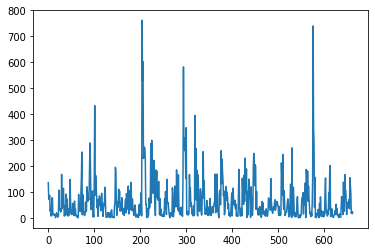

In [11]:
total_words_per_season = [len(X['all_words'][i]) for i in range(X.shape[0])]
print('Max number of words per season', np.max(total_words_per_season))
print('Mean number of words per season', np.mean(total_words_per_season))
print('Min number of words per season', np.min(total_words_per_season))
from utils.text_preprocessing_utils import read_glove_embeddings
all_words = []
for idx in range(X.shape[0]):
    all_words = all_words + X['all_words'][idx]
print('Number of unique words are', len(set(all_words)))

plt.plot(total_words_per_season)
plt.show()

# Based on the following, we decide to pad/truncate to max 200 words and use an embedding matrix of 2140 words.

In [12]:
from utils.text_preprocessing_utils import read_glove_embeddings, compute_relevant_embedding_matrix

EMBEDDING_DIM = 25
MAX_WORDS = 2147
MAX_LEN = 200

# Load the embeddings from Glove lowest dimensional trained embeddings
embeddings = read_glove_embeddings('../glove.twitter.27B.25d.txt')

# Get the matrix fo embeddings and mapping of words to rows in the embeddings matrix
embedding_matrix, map_word_to_idx = compute_relevant_embedding_matrix(embeddings, all_words, MAX_WORDS,  EMBEDDING_DIM)

def convert_word_to_id(words):
    return [map_word_to_idx[w] for w in words if w in map_word_to_idx]

# Convert the words to their idx in the matrix
X['all_words'] = X['all_words'].map(convert_word_to_id)

Embeddings containing 1193514 word vectors.


## Fusion model between numerical and embeddings

In [13]:
from utils.models import get_embedding_submodel, get_numerical_submodel, get_combined_model

tf.keras.backend.clear_session()
model_embedding = get_embedding_submodel( MAX_LEN, MAX_WORDS, EMBEDDING_DIM, embedding_matrix)

# The model to contain the embeddings
print("Embeddings model")
model_embedding.summary()

Embeddings model
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_input (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 25)           53675     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                23040     
Total params: 76,715
Trainable params: 23,040
Non-trainable params: 53,675
_________________________________________________________________


In [14]:
model_numerical = get_numerical_submodel(10)

# The model to contain the numerical values
print("Numerical model")
model_numerical.summary()

Numerical model
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_input (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
num_dense (Dense)            (None, 64)                704       
Total params: 704
Trainable params: 704
Non-trainable params: 0
_________________________________________________________________


In [15]:
from utils.models import get_numerical_model_x_inputs, get_embeddings_model_x_inputs, local_seed

def train_and_predict_fusion_model(x_train, x_test, y_train, y_test):
    x_train_1, x_test_1 = get_embeddings_model_x_inputs(x_train, x_test, MAX_LEN)
    x_train_2, x_test_2 = get_numerical_model_x_inputs(x_train, x_test)

    with local_seed(10):
        tf.keras.backend.clear_session()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

        class_weights = get_class_weights(Y)
        model = get_combined_model(model_embedding, model_numerical)
        result = model.fit({'input_1': x_train_1, 'input_2': x_train_2},
            y_train, 
            batch_size = 32, 
            epochs=10,
            callbacks=[es],
            validation_data=({'input_1': x_test_1, 'input_2': x_test_2}, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step({'input_1': x_test_1, 'input_2': x_test_2}).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, stratify=Y, test_size=0.2, shuffle=True)
train_and_predict_fusion_model(x_train, x_test, y_train, y_test )

# f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_fusion_model, 10, stratify=True, model_name="Fusion model")
# print('Average f1', f1_output[0])
# print('Average mmc', mmc_output[0])

{'acc': 76.549,
 'f1': 0.395,
 'fn': 2158,
 'fp': 5350,
 'mmc': 0.204542,
 'precision': 0.195,
 'recall': 0.376,
 'tn': 8881,
 'tp': 1300}

## Embeddings only model

In [22]:
from utils.models import get_embedding_model_only

def train_and_predict_embedding_model(x_train, x_test, y_train, y_test):
    x_train_1, x_test_1 = get_embeddings_model_x_inputs(x_train, x_test, MAX_LEN)

    with local_seed(10):
        tf.keras.backend.clear_session()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
    
        class_weights = get_class_weights(Y)
        model = get_embedding_model_only(MAX_LEN, MAX_WORDS, EMBEDDING_DIM, embedding_matrix)
        result = model.fit(x_train_1,
            y_train, 
            batch_size = 64, 
            epochs=15,
            callbacks=[es],
            validation_data=(x_test_1, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step(x_test_1).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)


# x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2, shuffle=True)
# train_and_predict_embedding_model(x_train, x_test, y_train, y_test)
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_embedding_model, 20, stratify=True, model_name="Embeddings only model")

Training model Embeddings only model..


/home/ina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in lon

Average F1-Score: 0.232
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.435
Matthews Corr Coef: 95% confidence interval -0.139 and 0.150


# How early can we predict betrayal?

## Two seasons before betrayal

The method we use to check this:
- we use all relationships, even the non-betrayal, that we know will not end up with betrayal
- we move back in time in each relationship at the point all relationships are two seasons away from betrayal
- we label all seasons that are two seasons away of betrayal with the with the imminent outcome and the rest with 0

In [110]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 2]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features_before['season_before_betrayal'] == 2.0).values.astype('float32')
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,n_sentences,politeness,delta_role_politeness,delta_time_politeness,friendship_length
0,1.333333,1.333333,1.500000,3.666667,489,25,0.803328,-0.006665,0.000000,3.0
1,0.142857,0.857143,1.285714,1.285714,280,16,0.560083,-0.225425,-0.249910,3.0
2,2.000000,2.500000,2.000000,5.500000,333,13,0.982703,0.375372,0.197195,3.0
3,1.800000,0.800000,2.200000,3.200000,449,24,0.748802,0.177667,0.141471,3.0
4,1.000000,1.000000,1.000000,2.000000,78,6,0.899161,0.335738,0.328027,3.0


In [112]:
bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="")

Training model ..
Average F1-Score: 0.493
Average MMC-Score: 0.271
F1-Score: 95% confidence interval 0.214 and 0.722
Matthews Corr Coef: 95% confidence interval -0.125 and 0.570


([0.493, 0.03378679281052069], [0.27091984999999996, 0.04371000036443996])

## Three seasons before betrayal

In [113]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 3]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features_before['season_before_betrayal'] == 3.0).values.astype('float32')

In [114]:
bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="")

Training model ..
Average F1-Score: 0.386
Average MMC-Score: 0.195
F1-Score: 95% confidence interval 0.231 and 0.556
Matthews Corr Coef: 95% confidence interval -0.010 and 0.399


([0.38594999999999996, 0.022448944999241],
 [0.19491680000000003, 0.03118587636411545])

## Four seasons before betrayal

In [115]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 4]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features_before['season_before_betrayal'] == 4.0).values.astype('float32')

In [117]:
bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.398
Average MMC-Score: 0.356
F1-Score: 95% confidence interval 0.189 and 0.667
Matthews Corr Coef: 95% confidence interval 0.121 and 0.572


([0.39835, 0.03221133136678849], [0.356441, 0.030636611902393755])

# Let's help the player win!

We want to see if we can better predict a future betrayal by using more than the previous season before betrayal. 

### Using two seasons up to betrayal

In [124]:
X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal']  <= 2.0).values.astype('int')

In [127]:
f1_scores, mmc_scores = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.612
Average MMC-Score: 0.349
F1-Score: 95% confidence interval 0.462 and 0.761
Matthews Corr Coef: 95% confidence interval 0.120 and 0.539


In [133]:
bootstrap_model_prediction(train_and_predict_random_forest, 4, stratify=False, model_name="Random Forest")

Training model Random Forest..


/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))


Average F1-Score: 0.000
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.000
Matthews Corr Coef: 95% confidence interval -0.148 and 0.000


/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/home/ina/Repos/EPFL/ADA-Project-Milestone3/utils/evaluation_utils.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (TN * TP - FP * FN) / np.sqrt((TN + FN) * (FP + TP) * (TN + FP) * (FN + TP))


([0.0, 0.0], [nan, nan])

### Using three seasons up to betrayal

In [134]:
X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal']  <= 3.0).values.astype('int')

In [135]:
f1_scores, mmc_scores = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.624
Average MMC-Score: 0.278
F1-Score: 95% confidence interval 0.530 and 0.757
Matthews Corr Coef: 95% confidence interval 0.094 and 0.463


In [136]:
bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=False, model_name="Random Forest")

Training model Random Forest..
Average F1-Score: 0.654
Average MMC-Score: 0.250
F1-Score: 95% confidence interval 0.596 and 0.724
Matthews Corr Coef: 95% confidence interval 0.165 and 0.307


([0.654, 0.024312548200466362], [0.2502904, 0.026682024313383724])